# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.

It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.util as util
import gssi_experiment.util.prometheus_raw_data_helper as prom_data_helper
import gssi_experiment.util.gg_figure_helper as gg_fig

pincirollis_data_path = (
    "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/multi_N25.csv"
)

fig_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures/'

synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/pinciroli_replication_22_jan_24/"

## Dataframe creation


### Load experimental data

In [2]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["gateway-aggregator", "s1", "s2", "s3"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=2
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate s3 intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(experiment_folder).split("_")[0])
        s3_intensity = 1 - (step / max_steps)

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            s3_intensity,
            avg_latency,
            cpu_limit,
            replicas,
            metadata["start_time"],
            metadata["end_time"],
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    "s3_intensity",
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df.describe()

Retrying to calculate averages with services: ['gateway-aggregator', 's1', 's2', 's3.1']
Retrying to calculate averages with services: ['gateway-aggregator', 's1', 's2', 's3.1']


,step,max_step,s3_intensity,avg_latency_ms,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3
count,36.000000,36.0,36.00000,36.000000,36.0,36.000000,36.000000,36.000000,36.000000
mean,2.500000,5.0,0.50000,1104.758345,1.0,0.041090,0.704544,0.778461,0.667938
std,1.732051,0.0,0.34641,151.339141,0.0,0.005206,0.226665,0.134202,0.244547
min,0.000000,5.0,0.00000,915.880587,1.0,0.032824,0.323462,0.580708,0.268343
25%,1.000000,5.0,0.20000,980.332358,1.0,0.036189,0.524318,0.668762,0.483418
50%,2.500000,5.0,0.50000,1063.431488,1.0,0.041879,0.750447,0.751726,0.766664
75%,4.000000,5.0,0.80000,1228.694753,1.0,0.045327,0.913522,0.918395,0.885061
max,5.000000,5.0,1.00000,1368.328755,1.0,0.050193,0.945693,0.938891,0.941463


### Load synthetic delay data

In [3]:
synth_delay_cols = ["N_A", "R0"]
pinc_df = synth_df[synth_delay_cols]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df.describe()

/tmp/ipykernel_10534/303495243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,step,max_step,s3_intensity,avg_latency_ms,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0
count,30.000000,30.0,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.200000,5.0,0.560000,1107.827216,1.0,0.041134,0.661304,0.794187,0.701514,405.966830
std,1.749877,0.0,0.349975,165.427593,0.0,0.005691,0.224413,0.141055,0.253735,61.777717
min,0.000000,5.0,0.000000,915.880587,1.0,0.032824,0.323462,0.580708,0.268343,342.748978
25%,1.000000,5.0,0.400000,968.657290,1.0,0.036100,0.480792,0.664892,0.589845,349.225049
50%,2.000000,5.0,0.600000,1028.362951,1.0,0.042897,0.700193,0.875961,0.819436,387.771535
75%,3.000000,5.0,0.800000,1235.599044,1.0,0.045538,0.904453,0.920137,0.890509,449.008131
max,5.000000,5.0,1.000000,1368.328755,1.0,0.050193,0.943072,0.938891,0.941463,501.080456


### Load synthetic CPU utilization data

In [4]:
synth_cpu_cols = ["N_A", "Ugw", "Us1", "Us2", "Us3"]
pinc_df = synth_df[synth_cpu_cols]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df.describe()

/tmp/ipykernel_10534/732592599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,step,max_step,s3_intensity,avg_latency_ms,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Ugw,Us1,Us2,Us3
count,30.000000,30.0,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.200000,5.0,0.560000,1107.827216,1.0,0.041134,0.661304,0.794187,0.701514,405.966830,0.629850,0.769329,0.854013,0.812067
std,1.749877,0.0,0.349975,165.427593,0.0,0.005691,0.224413,0.141055,0.253735,61.777717,0.090663,0.244190,0.131435,0.277739
min,0.000000,5.0,0.000000,915.880587,1.0,0.032824,0.323462,0.580708,0.268343,342.748978,0.498132,0.350410,0.663446,0.280486
25%,1.000000,5.0,0.400000,968.657290,1.0,0.036100,0.480792,0.664892,0.589845,349.225049,0.560574,0.665800,0.739736,0.828684
50%,2.000000,5.0,0.600000,1028.362951,1.0,0.042897,0.700193,0.875961,0.819436,387.771535,0.645042,0.859453,0.910665,0.951204
75%,3.000000,5.0,0.800000,1235.599044,1.0,0.045538,0.904453,0.920137,0.890509,449.008131,0.716111,0.971041,0.970597,0.999964
max,5.000000,5.0,1.000000,1368.328755,1.0,0.050193,0.943072,0.938891,0.941463,501.080456,0.729392,0.999943,0.985620,1.000000


# Request Delay


## Visualization


averaged_columns={'Us2', 'cpu_utilization_gateway-aggregator', 'cpu_utilization_s2', 'Us1', 'Us3', 'avg_latency_ms', 'cpu_utilization_s1', 'R0', 'cpu_utilization_s3', 'Ugw', 'N_A'}
output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//req_latency_abs.png'


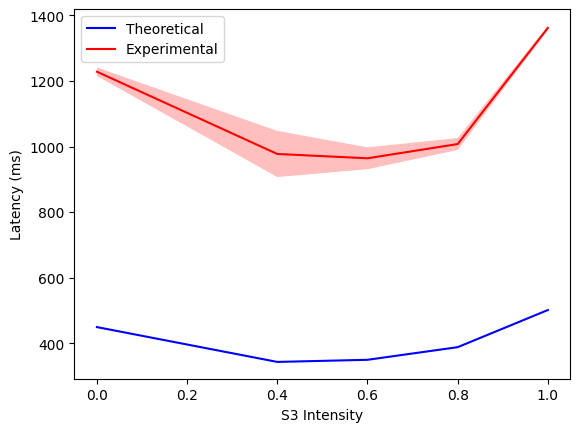

In [5]:
averaged_columns = set(["avg_latency_ms", "R0", *synth_cpu_cols, *cpu_columns])
group_columns = ["s3_intensity"]
avg_df = nb_helper.to_averaged_df(df, group_columns, averaged_columns)

output_path = f"{fig_path}/req_latency_abs.png"
nb_helper.create_figure(
    avg_df, "s3_intensity", "R0", "avg_latency_ms", "Latency (ms)", output_path
)

In [6]:
# Ouputs figure for paper.
output_path = f"{fig_path}/paper_figures/ga_req_latency_abs.pdf"
gg_fig.make_line_chart(
    df=avg_df,
    x_key="s3_intensity",
    y_keys=["R0", "avg_latency_ms"],
    x_label="S3 Intensity",
    y_label="Response Time (ms)",
    line_labels=["Theoretical", "Experimental"],
    y_std_keys=[None, "std_avg_latency_ms"],
    figure_output_path=output_path,
)

figure_output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//paper_figures/ga_req_latency_abs.pdf'


averaged_columns={'Us2', 'cpu_utilization_gateway-aggregator', 'cpu_utilization_s2', 'Us1', 'Us3', 'avg_latency_ms', 'cpu_utilization_s1', 'R0', 'cpu_utilization_s3', 'Ugw', 'N_A'}
output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//req_latency_norm.png'


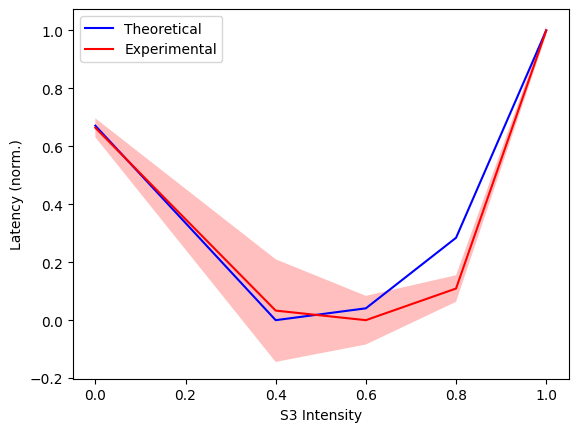

In [7]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = df.copy()
df_norm = nb_helper.to_averaged_df(df_norm, group_columns, averaged_columns)
fields = ["R0", "avg_latency_ms"]
for field in fields:
    df_norm, min_y, max_y = nb_helper.normalize_field_and_yield_min_max(df_norm, field)
    delta_y = max_y - min_y
    df_norm[f"std_{field}"] = df_norm[f"std_{field}"].transform(lambda x: x / delta_y)

output_path = f"{fig_path}/req_latency_norm.png"
nb_helper.create_figure(
    df_norm, "s3_intensity", "R0", "avg_latency_ms", "Latency (norm.)", output_path
)

In [8]:
# Plots figure for the paper.
output_path = f"{fig_path}/paper_figures/ga_req_latency_norm.pdf"
gg_fig.make_line_chart(
    df=df_norm,
    x_key="s3_intensity",
    y_keys=["R0", "avg_latency_ms"],
    x_label="S3 Intensity",
    y_label="Response Time (norm.)",
    line_labels=["Theoretical", "Experimental"],
    y_std_keys=[None, "std_avg_latency_ms"],
    figure_output_path=output_path,
)

figure_output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//paper_figures/ga_req_latency_norm.pdf'


## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [9]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

sig = "significant" if p_value < 0.05 else "insignificant"
print("Spearman's correlation coefficient:")
print(f"avg_latency_ms: {correlation_coefficient=:.3f} ({p_value=:.3f} = {sig})")

Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.869 (p_value=0.000 = significant)


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [10]:
from gssi_experiment.util.stat_helper import mae, mape

absolute_mape = mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=:.2f}%, {normalized_mape=:.2f}% ({eps=})")

absolute_mape=63.34%, normalized_mape=4.70% (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [11]:
absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = 100 * mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")

absolute_mae=701.860, normalized_mae=5.12%


# CPU Utilization


## Visualization


averaged_columns={'Us2', 'cpu_utilization_gateway-aggregator', 'cpu_utilization_s2', 'Us1', 'Us3', 'avg_latency_ms', 'cpu_utilization_s1', 'R0', 'cpu_utilization_s3', 'Ugw', 'N_A'}
output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//cpu_util_abs.png'


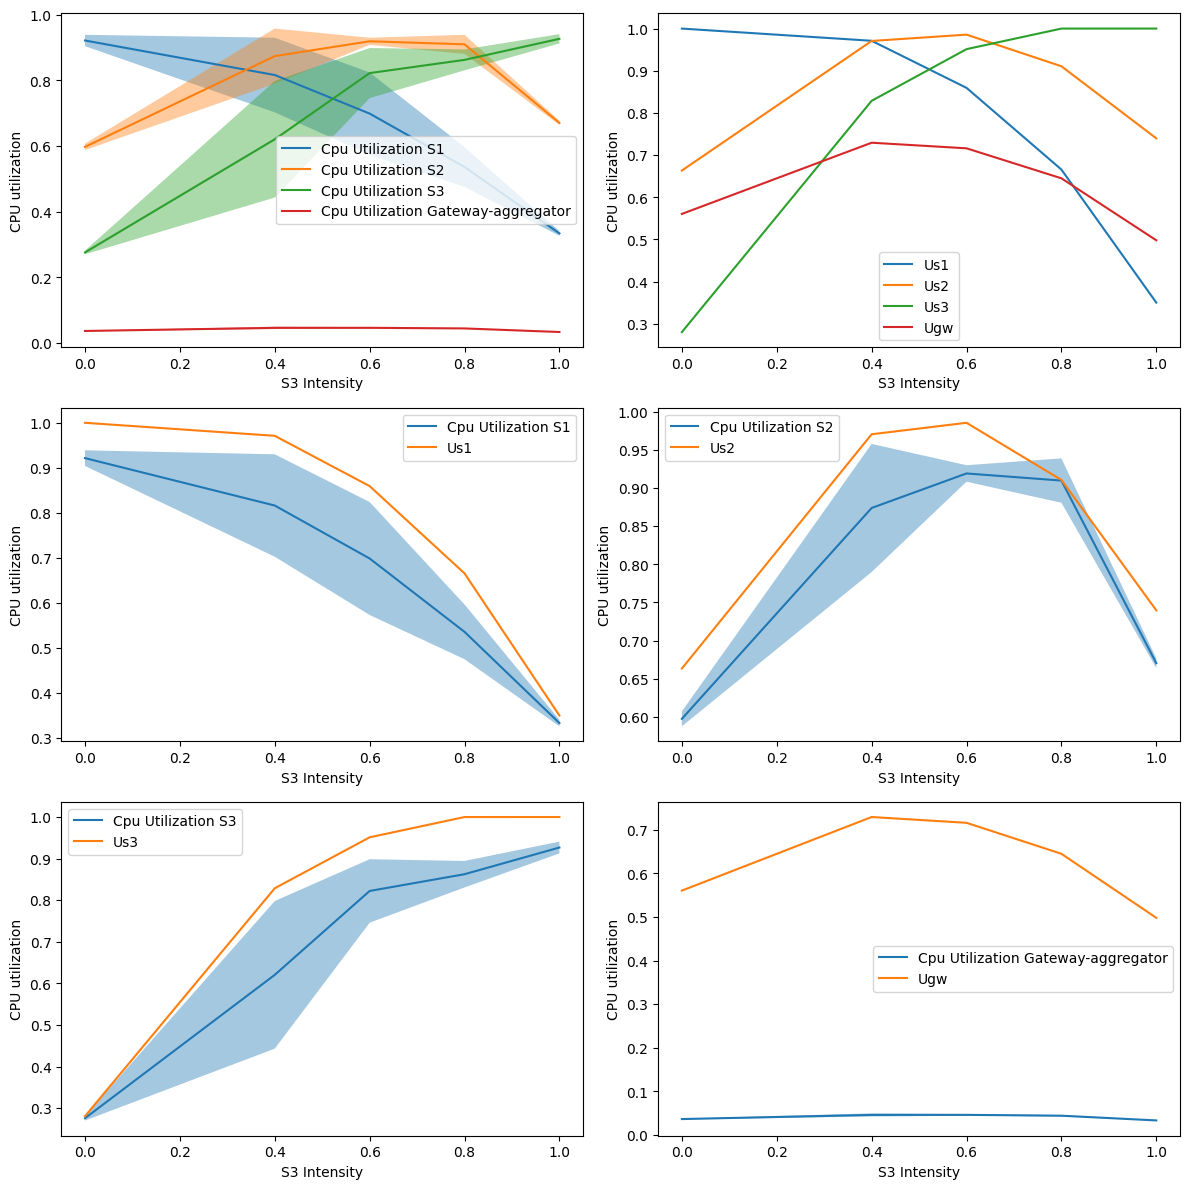

In [12]:
def plot_comparisons(comparison_tuples, df):
    # Calculate the number of subplots based on the length of comparison_tuples
    num_subplots = len(comparison_tuples)
    # Determine the number of rows and columns for the subplots
    num_rows = num_subplots // 2  # Assuming 2 columns
    num_cols = 2  # Number of columns for the subplots

    # Create a larger figure with subplots
    _, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

    # Flatten the axes array if there is more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, columns in enumerate(comparison_tuples):
        # Select the current subplot
        ax = axes[i]

        # Plot a line diagram for each pair of columns in the DataFrame
        x_column = "s3_intensity"
        for column in columns:
            df.plot(x=x_column, y=column, ax=ax, label=nb_helper.de_snake_case(column))
            std_column = f"std_{column}"
            upper = df[column] + df[std_column]
            lower = df[column] - df[std_column]
            ax.fill_between(df[x_column], upper, lower, alpha=0.25)


        ax.set_xlabel("S3 Intensity")
        ax.set_ylabel("CPU utilization")

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()


comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gateway-aggregator",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]

avg_df = nb_helper.to_averaged_df(df, group_columns, averaged_columns)

output_path = f'{fig_path}/cpu_util_abs.png'
nb_helper.create_plot_comparisons(comparison_tuples, avg_df, 's3_intensity', output_path)

In [13]:
# Plots figure for the paper.

# Experimental CPU Util.
output_path = f"{fig_path}/paper_figures/ga_cpu_util_experimental_abs.pdf"
gg_fig.make_line_chart(
    df=df_norm,
    x_key="s3_intensity",
    y_keys=[
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gateway-aggregator",
    ],
    x_label="S3 Intensity",
    y_label="CPU Utilization",
    line_labels=["S1", "S2", "S3", "GW"],
    y_std_keys=[
        "std_cpu_utilization_s1",
        "std_cpu_utilization_s2",
        "std_cpu_utilization_s3",
        "std_cpu_utilization_gateway-aggregator",
    ],
    figure_output_path=output_path,
    legend_position=("center", (0.5, 0.25)),
)

# Theoretical CPU Util
output_path = f"{fig_path}/paper_figures/ga_cpu_util_theoretical_abs.pdf"
gg_fig.make_line_chart(
    df=df_norm,
    x_key="s3_intensity",
    y_keys=["Us1", "Us2", "Us3", "Ugw"],
    x_label="S3 Intensity",
    y_label="CPU Utilization",
    line_labels=["S1", "S2", "S3", "GW"],
    figure_output_path=output_path,
)

figure_output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//paper_figures/ga_cpu_util_experimental_abs.pdf'
figure_output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//paper_figures/ga_cpu_util_theoretical_abs.pdf'


averaged_columns={'Us2', 'cpu_utilization_gateway-aggregator', 'cpu_utilization_s2', 'Us1', 'Us3', 'avg_latency_ms', 'cpu_utilization_s1', 'R0', 'cpu_utilization_s3', 'Ugw', 'N_A'}
output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//cpu_util_norm.png'


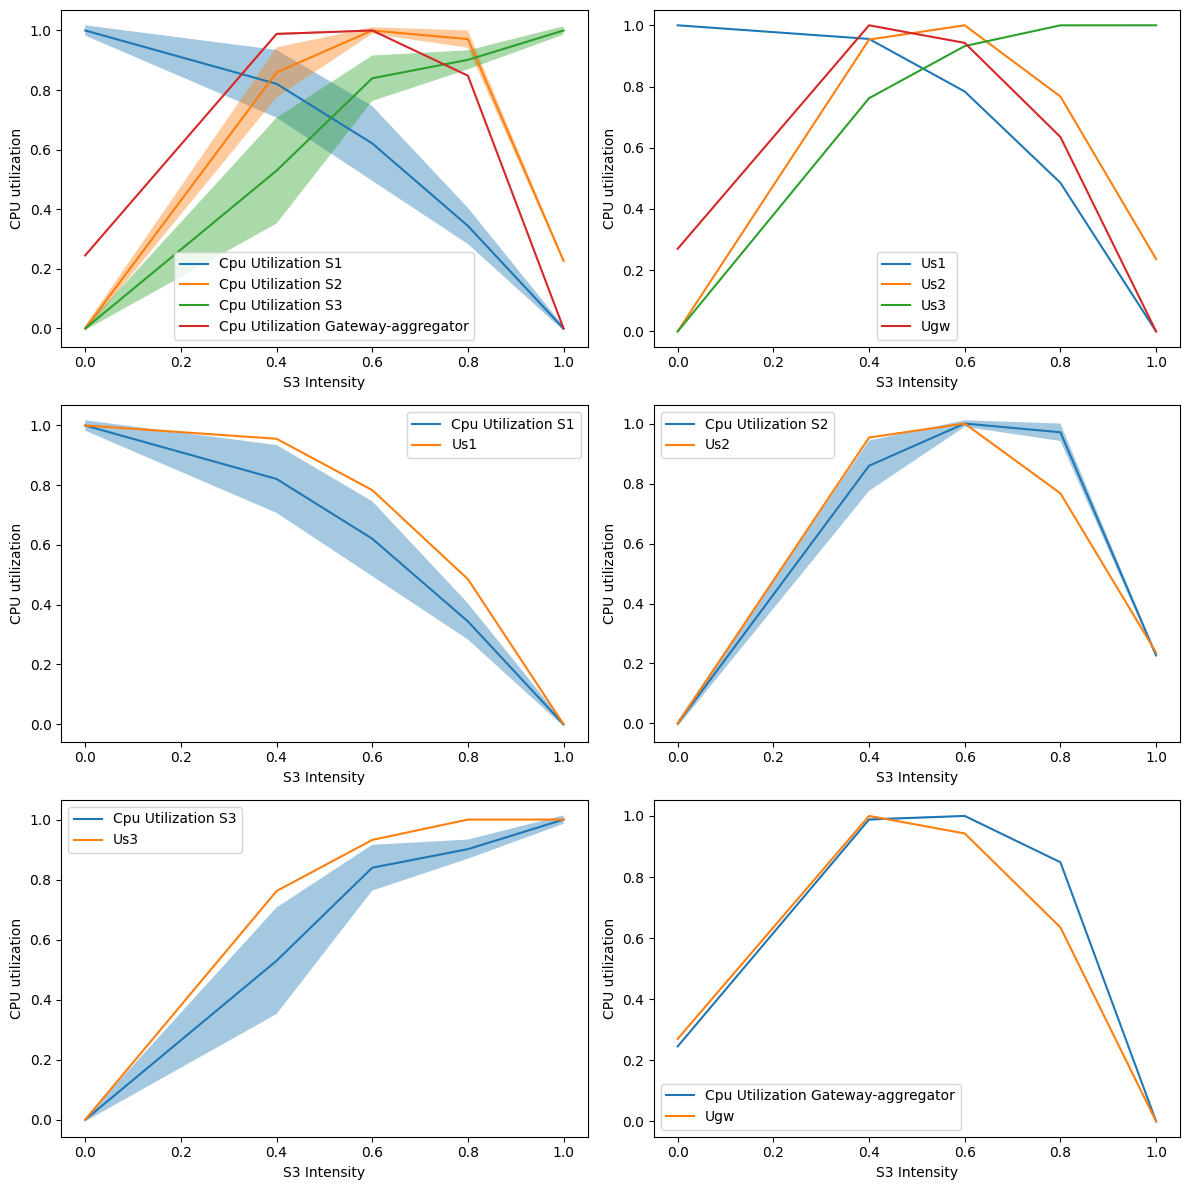

In [14]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gateway-aggregator",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]

avg_norm_df = nb_helper.to_averaged_df(df.copy(), group_columns, averaged_columns)

norm_cols = list(util.flatten(comparison_tuples))

for col in norm_cols:
    if col.startswith("std_"):
        continue
    avg_norm_df, min_y, max_y = nb_helper.normalize_field_and_yield_min_max(
        avg_norm_df, col
    )
    delta_y = max_y - min_y
    if not col in norm_cols:
        avg_norm_df[f"std_{col}"] = avg_norm_df[f"std_{col}"].transform(
            lambda x: x / delta_y
        )

output_path = f"{fig_path}/cpu_util_norm.png"
nb_helper.create_plot_comparisons(
    comparison_tuples, avg_norm_df, "s3_intensity", output_path
)

In [15]:
# Outputs paper figures
# Gateway CPU Util
output_path = f"{fig_path}/paper_figures/ga_cpu_util_gateway.pdf"
gg_fig.make_line_chart(
    df=avg_norm_df,
    x_key="s3_intensity",
    y_keys=["Ugw", "cpu_utilization_gateway-aggregator"],
    x_label="S3 Intensity",
    y_label="CPU Utilization",
    line_labels=["Theoretical", "Experimental"],
    y_std_keys=[None, "std_cpu_utilization_gateway-aggregator"],
    figure_output_path=output_path,
)

figure_output_path='/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/figures//paper_figures/ga_cpu_util_gateway.pdf'


## Evaluation


In [16]:
comparison_tuples = [
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]

### Spearman's correlation coefficient


In [17]:
print("Spearman's correlation coefficient:")
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    sig = "significant" if p_value < 0.05 else "insignificant"
    print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} = {sig})")

Spearman's correlation coefficient:
cpu_utilization_s1: 0.931 (p_value=0.000 = significant)
cpu_utilization_s2: 0.782 (p_value=0.000 = significant)
cpu_utilization_s3: 0.934 (p_value=0.000 = significant)
cpu_utilization_gateway-aggregator: 0.871 (p_value=0.000 = significant)


### Mean average (percentage) error


In [18]:
# Takes average of the df
avg_df = nb_helper.to_averaged_df(df.copy(), group_columns, averaged_columns)

# Normalizes individual values according to averaged values.
tested_df: pd.DataFrame = df.copy()
norm_cols = util.flatten(comparison_tuples)
for col in norm_cols:
    min_y, max_y = min(avg_df[col]), max(avg_df[col])
    tested_df[col] = tested_df[col].transform(lambda y: normalize(y, min_y, max_y))

for real, expected in comparison_tuples:
    mape_score = mape(df[expected], df[real])
    mae_score = 100 * mae(df[expected], df[real])
    print(f"{real}: {mape_score=:.2f}%, {mae_score=:.2f}%")

    eps = 1
    norm_mape_score = mape(tested_df[expected] + eps, tested_df[real] + eps)
    norm_mae_score = 100 * mae(tested_df[expected], tested_df[real])
    print(f"{real}: {norm_mape_score=:.2f}% ({eps=}), {norm_mae_score=:.2f}%\n")

averaged_columns={'Us2', 'cpu_utilization_gateway-aggregator', 'cpu_utilization_s2', 'Us1', 'Us3', 'avg_latency_ms', 'cpu_utilization_s1', 'R0', 'cpu_utilization_s3', 'Ugw', 'N_A'}
cpu_utilization_s1: mape_score=17.48%, mae_score=10.80%
cpu_utilization_s1: norm_mape_score=7.37% (eps=1), norm_mae_score=10.66%

cpu_utilization_s2: mape_score=8.63%, mae_score=6.41%
cpu_utilization_s2: norm_mape_score=5.25% (eps=1), norm_mae_score=8.87%

cpu_utilization_s3: mape_score=18.11%, mae_score=11.08%
cpu_utilization_s3: norm_mape_score=6.48% (eps=1), norm_mae_score=9.42%

cpu_utilization_gateway-aggregator: mape_score=1431.86%, mae_score=58.87%
cpu_utilization_gateway-aggregator: norm_mape_score=6.91% (eps=1), norm_mae_score=12.20%



In [19]:
import datetime

print(datetime.datetime.now())

2024-02-03 11:19:00.833511
